In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn import metrics
import cv2
import gc
import os
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
import warnings
import h5py
warnings.filterwarnings('ignore')
path = r'/content/drive/MyDrive/lung_image_sets'


In [ ]:


classes = os.listdir(path)
classes

['lung_aca', 'lung_scc']

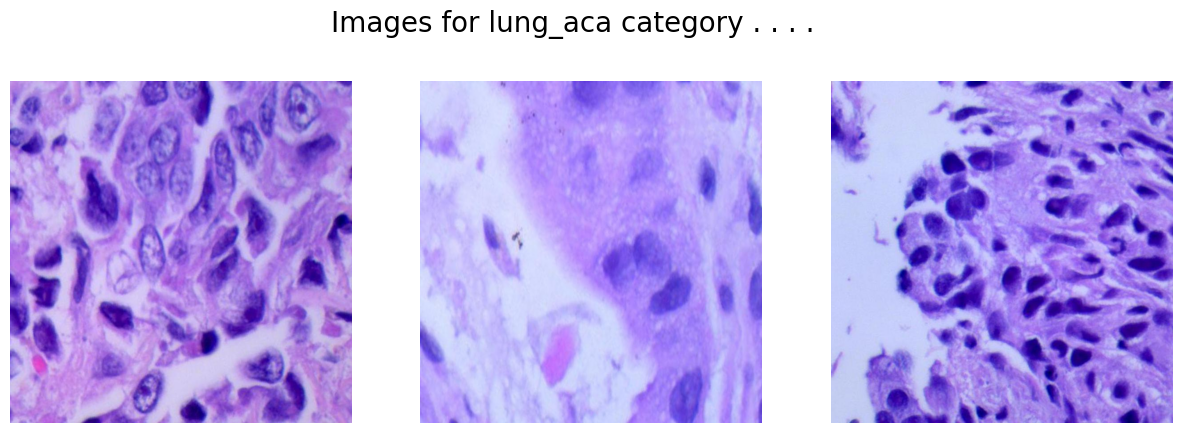

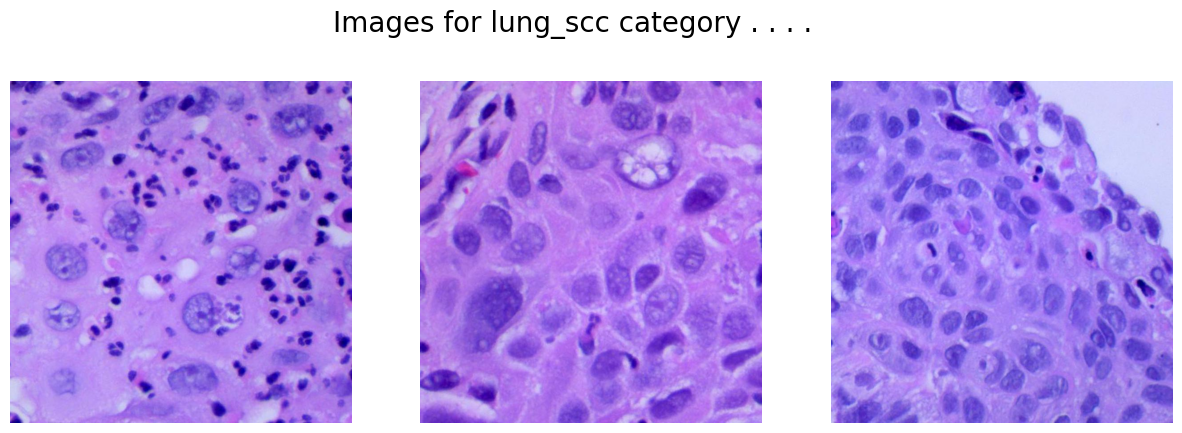

In [ ]:
for cat in classes:
    image_dir = f'{path}/{cat}'
    images = os.listdir(image_dir)

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Images for {cat} category . . . .', fontsize=20)

    for i in range(3):
        k = np.random.randint(0, len(images))
        img = np.array(Image.open(f'{path}/{cat}/{images[k]}'))
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()


In [ ]:
# Constants
IMG_SIZE = 128
SPLIT = 0.2
EPOCHS = 15
BATCH_SIZE = 50
REG_CONSTANT = 0.001  # Regularization constant for L2 regularization

In [ ]:
X = []
Y = []

# Load and process images
for i, cat in enumerate(classes):
    images = glob(f'{path}/{cat}/*.jpeg')
    for image in images:
        img = cv2.imread(image)
        if img is not None:
            resized_img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            X.append(resized_img)
            Y.append(i)

X = np.array(X)
Y = pd.get_dummies(Y).values  # One-hot encoding of labels
# Check if the label encoding is correct (3 classes expected)
print("Unique classes:", np.unique(Y, axis=0).shape[0])
print("Shape of Y:", Y.shape)


In [ ]:
# Split data into train, validate, and test sets
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.4, random_state=2022, stratify=np.argmax(Y, axis=1))
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=2022, stratify=np.argmax(Y_temp, axis=1))

print(X_train.shape, X_val.shape, X_test.shape)

In [ ]:
# Define custom CNN Model
custom_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(REG_CONSTANT)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(REG_CONSTANT)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(REG_CONSTANT)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(REG_CONSTANT)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(REG_CONSTANT)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(len(classes), activation='softmax')
])


In [ ]:
# Load VGG16 Model
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
# Freeze the layers except the last 4 layers
for layer in base_model.layers[:-4]:
    layer.trainable = False
# Create the VGG16 model
vgg_model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(len(classes), activation='softmax')
])

In [ ]:
# Compile the models
custom_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
vgg_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Callbacks
es = EarlyStopping(monitor='val_loss', patience=2)
lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)

In [ ]:
# Fit the custom model
print("Training custom model...")
custom_history = custom_model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    #callbacks=[es, lr]
)

In [ ]:
# Fit the VGG16 model
print("Training VGG16 model...")
vgg_history = vgg_model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    #callbacks=[es, lr]
)

In [ ]:
# Evaluate the custom model on the test set
custom_test_loss, custom_test_acc = custom_model.evaluate(X_test, Y_test)
print('Custom model test accuracy:', custom_test_acc)

# Evaluate the VGG16 model on the test set
vgg_test_loss, vgg_test_acc = vgg_model.evaluate(X_test, Y_test)
print('VGG16 model test accuracy:', vgg_test_acc)

94/94 [==============================] - 1s 9ms/step - loss: 0.2963 - accuracy: 0.9350
Custom model test accuracy: 0.9350432753562927
94/94 [==============================] - 9s 69ms/step - loss: 0.0647 - accuracy: 0.9803
VGG16 model test accuracy: 0.9803464412689209


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import numpy as np


In [ ]:
# Predict classes with custom model
custom_pred = custom_model.predict(X_test)
custom_pred_classes = np.argmax(custom_pred, axis=1)

# Predict classes with VGG16 model
vgg_pred = vgg_model.predict(X_test)
vgg_pred_classes = np.argmax(vgg_pred, axis=1)

# True classes
true_classes = np.argmax(Y_test, axis=1)


94/94 [==============================] - 4s 41ms/step


In [ ]:
# Confusion matrix for the custom model
custom_cm = confusion_matrix(true_classes, custom_pred_classes)
# Confusion matrix for the VGG16 model
vgg_cm = confusion_matrix(true_classes, vgg_pred_classes)


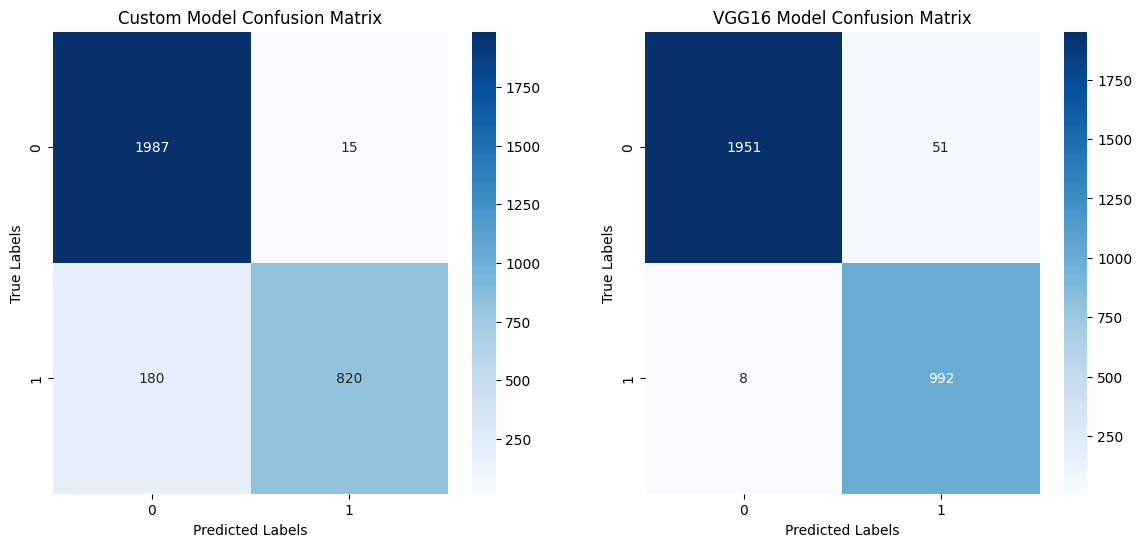

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
sns.heatmap(custom_cm, annot=True, fmt='d', ax=ax[0], cmap='Blues')
ax[0].set_title('Custom Model Confusion Matrix')
ax[0].set_xlabel('Predicted Labels')
ax[0].set_ylabel('True Labels')

sns.heatmap(vgg_cm, annot=True, fmt='d', ax=ax[1], cmap='Blues')
ax[1].set_title('VGG16 Model Confusion Matrix')
ax[1].set_xlabel('Predicted Labels')
ax[1].set_ylabel('True Labels')

plt.show()


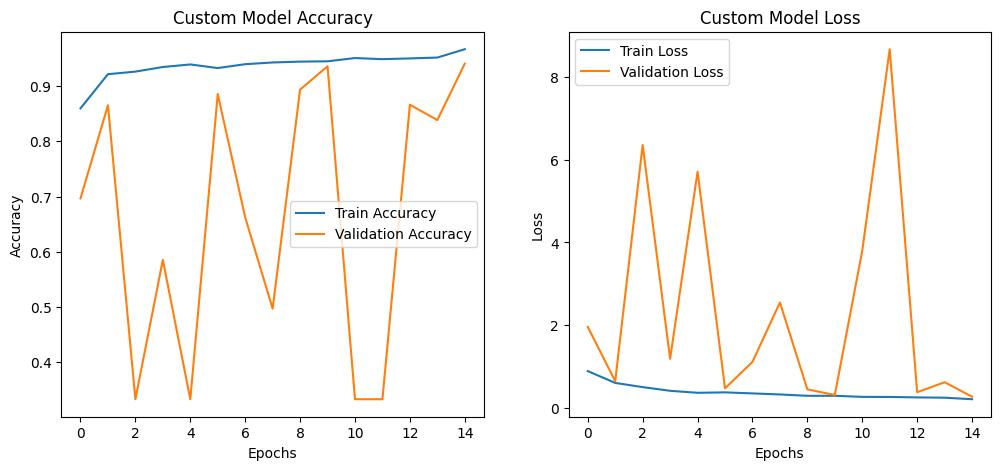

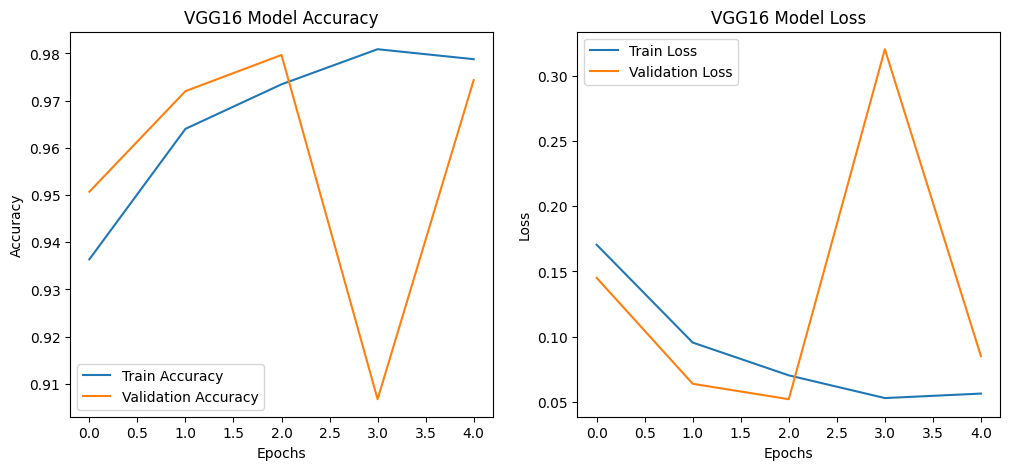

In [ ]:
# Plot for custom model
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(custom_history.history['accuracy'], label='Train Accuracy')
plt.plot(custom_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Custom Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(custom_history.history['loss'], label='Train Loss')
plt.plot(custom_history.history['val_loss'], label='Validation Loss')
plt.title('Custom Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot for VGG16 model
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(vgg_history.history['accuracy'], label='Train Accuracy')
plt.plot(vgg_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('VGG16 Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(vgg_history.history['loss'], label='Train Loss')
plt.plot(vgg_history.history['val_loss'], label='Validation Loss')
plt.title('VGG16 Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# For Custom Model
# Calculate metrics for the custom model
custom_accuracy = accuracy_score(true_classes, custom_pred_classes)
custom_precision = precision_score(true_classes, custom_pred_classes, average='weighted')
custom_recall = recall_score(true_classes, custom_pred_classes, average='weighted')
custom_f1 = f1_score(true_classes, custom_pred_classes, average='weighted')

print("Custom Model Metrics:")
print("Accuracy:", custom_accuracy)
print("Precision:", custom_precision)
print("Recall:", custom_recall)
print("F1 Score:", custom_f1)

# For VGG16 Model
# Calculate metrics for the VGG16 model
vgg_accuracy = accuracy_score(true_classes, vgg_pred_classes)
vgg_precision = precision_score(true_classes, vgg_pred_classes, average='weighted')
vgg_recall = recall_score(true_classes, vgg_pred_classes, average='weighted')
vgg_f1 = f1_score(true_classes, vgg_pred_classes, average='weighted')

print("\nVGG16 Model Metrics:")
print("Accuracy:", vgg_accuracy)
print("Precision:", vgg_precision)
print("Recall:", vgg_recall)
print("F1 Score:", vgg_f1)


Custom Model Metrics:
Accuracy: 0.9350433044636909
Precision: 0.9386214230180073
Recall: 0.9350433044636909
F1 Score: 0.9334083308052563

VGG16 Model Metrics:
Accuracy: 0.980346435709527
Precision: 0.9809883374052856
Recall: 0.980346435709527
F1 Score: 0.9804465866835609


94/94 [==============================] - 4s 40ms/step


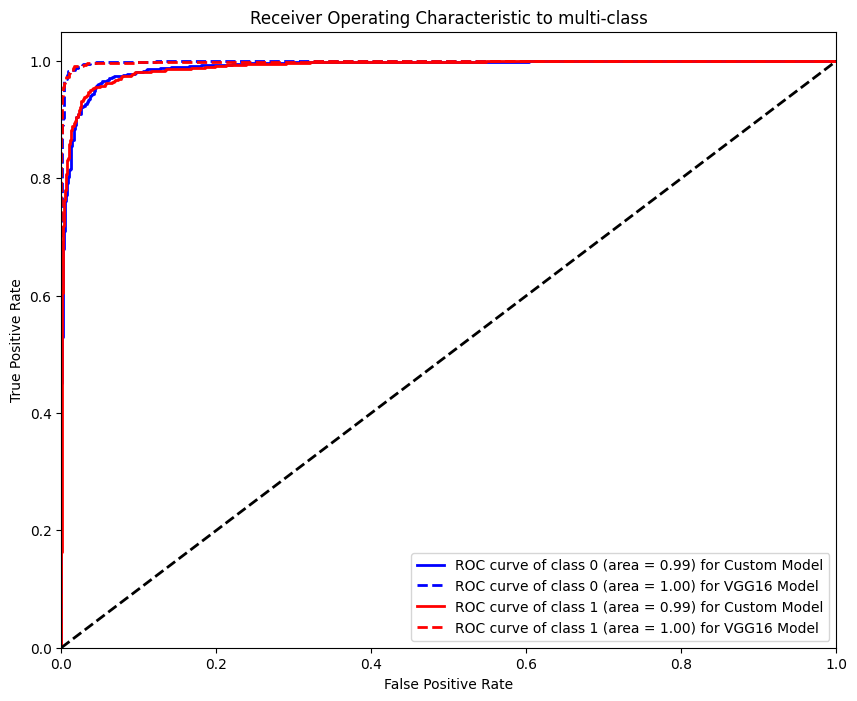

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
from itertools import cycle

# Determine unique classes and binarize
unique_classes = np.unique(Y)
Y_bin = label_binarize(Y, classes=unique_classes)
n_classes = Y_bin.shape[1]

# Assuming X_train, X_test split includes all possible classes
custom_prob = custom_model.predict(X_test)
vgg_prob = vgg_model.predict(X_test)

# Compute ROC curve and ROC area for each class for Custom Model
custom_fpr = dict()
custom_tpr = dict()
custom_roc_auc = dict()
for i in range(n_classes):
    custom_fpr[i], custom_tpr[i], _ = roc_curve(Y_test[:, i], custom_prob[:, i])
    custom_roc_auc[i] = auc(custom_fpr[i], custom_tpr[i])

# Compute ROC curve and ROC area for each class for VGG16 Model
vgg_fpr = dict()
vgg_tpr = dict()
vgg_roc_auc = dict()
for i in range(n_classes):
    vgg_fpr[i], vgg_tpr[i], _ = roc_curve(Y_test[:, i], vgg_prob[:, i])
    vgg_roc_auc[i] = auc(vgg_fpr[i], vgg_tpr[i])

# Plotting
colors = cycle(['blue', 'red', 'green', 'cyan', 'magenta'])
plt.figure(figsize=(10, 8))
for i, color in zip(range(n_classes), colors):
    plt.plot(custom_fpr[i], custom_tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f}) for Custom Model'.format(i, custom_roc_auc[i]))
    plt.plot(vgg_fpr[i], vgg_tpr[i], color=color, lw=2, linestyle='--',
             label='ROC curve of class {0} (area = {1:0.2f}) for VGG16 Model'.format(i, vgg_roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()
